# 1. Thermometer Encoding

In [1]:
from conx import Network
import numpy as np
import theano.tensor as T
import theano
import random

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

%matplotlib inline

## 1.1 Learning to add: one output

In [64]:
net = Network(2, 2, 1, activation_function=T.nnet.sigmoid)
#net.batch = True

In [65]:
# input low and high values:
ilo = -1
ihi = 1
# output low and high values:
olo = 0
ohi = 1

In [66]:
net.set_inputs([[random.random() * 2 - 1, random.random() * 2 - 1] for i in range(1000)])

In [75]:
f = lambda ins: [((ins[0] + ins[1])/2 + 1)/2]
net.set_target_function(f)

In [78]:
net.train(report_rate=20, tolerance=.05)

--------------------------------------------------
Training for max trails: 5000 ...
Epoch: 107 TSS error: 0.858317748173 %correct: 94.19999999999999
Epoch: 120 TSS error: 0.125718711285 %correct: 99.6
Epoch: 140 TSS error: 0.106452514751 %correct: 99.6
Epoch: 160 TSS error: 0.106062935761 %correct: 99.6
Epoch: 180 TSS error: 0.0940164321403 %correct: 99.7
Epoch: 200 TSS error: 0.107933787015 %correct: 99.7
Epoch: 220 TSS error: 0.0656636624831 %correct: 99.7
Epoch: 240 TSS error: 0.059195051214 %correct: 99.7
Epoch: 260 TSS error: 0.0597954341883 %correct: 99.7
Epoch: 280 TSS error: 0.0535763699632 %correct: 99.7
Epoch: 298 TSS error: 0.0835849762444 %correct: 99.7

Interrupted by user; stopping...


KeyboardInterrupt: 

In [79]:
net.test(10)

--------------------------------------------------
Test:
******************************
Input : -0.6, 0.5 
Output:  0.5 
Target:  0.5 Correct
******************************
Input : -0.2, 0.4 
Output:  0.6 
Target:  0.5 Correct
******************************
Input :  0.4,-0.6 
Output:  0.4 
Target:  0.4 Correct
******************************
Input : -0.9, 0.5 
Output:  0.4 
Target:  0.4 Correct
******************************
Input : -0.1, 0.5 
Output:  0.6 
Target:  0.6 Correct
******************************
Input : -0.1,-0.3 
Output:  0.4 
Target:  0.4 Correct
******************************
Input :  0.2,-0.2 
Output:  0.5 
Target:  0.5 Correct
******************************
Input :  0.5,-0.7 
Output:  0.5 
Target:  0.5 Correct
******************************
Input : -0.2, 0.6 
Output:  0.6 
Target:  0.6 Correct
******************************
Input : -0.2,-0.3 
Output:  0.4 
Target:  0.4 Correct
--------------------------------------------------
Epoch: 298 TSS error: 0.000942803980877 %c

## 1.2 Learning to add: thermometer encoding

In [30]:
def therm(v, size=10):
    """
    v - move range [ilo, ihi]
    returns thermometer encoding:
    [olo, olo, olo] 
    [ohi, olo, olo]
    [ohi, ohi, olo]
    [ohi, ohi, ohi]
    """
    ro = (ohi - olo) # output range
    ri = (ihi - ilo)
    t = (v - ilo) / ri # scale from input
    t_int = int(t * size) # int part
    t_float = round((t * size) - t_int, 2) # left over
    # left justified
    therm = ([ohi] * t_int + [t_float * ro + olo] + [olo] * size)[:size]
    return therm

def untherm(vec):
    """
    returns vec decoded - [ilo, ihi]
    """
    size = len(vec)
    ro = (ohi - olo) # range
    total = 0
    for v in vec:
        total += ((v - olo) / ro)
    scale = total/size
    return scale * ro + olo 

In [31]:
therm(-1)

[0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [32]:
therm(1)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [33]:
net = Network(2, 2, 10, activation_function=T.nnet.sigmoid)

In [35]:
net.set_inputs([[random.random() * 2 - 1, random.random() * 2 - 1] for i in range(1000)])

In [36]:
net.set_target_function(lambda ins: therm((ins[0] + ins[1])/2))

In [37]:
def test_net(net, res=20):
    m = np.zeros((res, res))
    step = (ihi - ilo)/res
    for i in range(res):
        for j in range(res):
            m[i][j] = untherm(net.propagate([ilo + i * step, ilo + j * step]))
    plt.matshow(m, 
                origin="lower", # lower puts 0,0 bottom left
                extent=[ilo,ihi,ilo,ihi], # tick label ranges
                cmap=cm.coolwarm,
                interpolation="none")
    plt.xlabel("input(0)")
    plt.ylabel("input(1)")
    plt.colorbar()

In [38]:
def plot_net(net, res=20, angle=45):
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Make data.
    X = np.arange(ilo, ihi, (ihi - ilo)/res)
    Y = np.arange(ilo, ihi, (ihi - ilo)/res)

    Z = np.array([[untherm(net.propagate([x, y])) for x in X] for y in Y])
    X, Y = np.meshgrid(X, Y)

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

    # Customize the z axis.
    ax.set_zlim(olo - 0.01, ohi + 0.01)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    ax.view_init(30, angle) # tilt, rotate

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()
    #display(fig)
    #fig.clear()

In [39]:
net.train(report_rate=20, tolerance=0.3)

--------------------------------------------------
Training for max trails: 5000 ...
Epoch: 0 TSS error: 2510.7056395 %correct: 0.0
Epoch: 20 TSS error: 22.7189946448 %correct: 96.2
Epoch: 40 TSS error: 85.0225704254 %correct: 69.1
Epoch: 60 TSS error: 15.1076404439 %correct: 98.7
Epoch: 80 TSS error: 12.4463664997 %correct: 98.7
Epoch: 100 TSS error: 12.5302482958 %correct: 98.8
Epoch: 120 TSS error: 7.34241388651 %correct: 98.8
Epoch: 140 TSS error: 17.810050253 %correct: 98.9
Epoch: 160 TSS error: 7.46909319898 %correct: 98.9
Epoch: 180 TSS error: 6.92952374574 %correct: 98.9
Epoch: 200 TSS error: 11.2168213265 %correct: 99.1
Epoch: 220 TSS error: 19.3624863711 %correct: 98.3
Epoch: 240 TSS error: 11.6882641271 %correct: 99.1
Epoch: 260 TSS error: 7.43680422059 %correct: 99.4
Epoch: 280 TSS error: 9.06550120717 %correct: 99.4
Epoch: 300 TSS error: 6.93877183779 %correct: 99.4
Epoch: 320 TSS error: 64.9006024766 %correct: 78.2
Epoch: 340 TSS error: 14.9153496545 %correct: 98.3
Epoch:

KeyboardInterrupt: 

In [40]:
net.test(10)

--------------------------------------------------
Test:
******************************
Input :  0.6, 0.9 
Output:  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7, 0.1 
Target:  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6, 0.0 Correct
******************************
Input :  0.2,-0.8 
Output:  1.0, 1.0, 1.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 
Target:  1.0, 1.0, 1.0, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 Correct
******************************
Input :  0.4, 0.2 
Output:  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4, 0.0, 0.0, 0.0 
Target:  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4, 0.0, 0.0, 0.0 Correct
******************************
Input :  0.1,-0.3 
Output:  1.0, 1.0, 1.0, 1.0, 0.3, 0.0, 0.0, 0.0, 0.0, 0.0 
Target:  1.0, 1.0, 1.0, 1.0, 0.3, 0.0, 0.0, 0.0, 0.0, 0.0 Correct
******************************
Input :  0.1, 0.2 
Output:  1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.1, 0.0, 0.0, 0.0 
Target:  1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.0, 0.0, 0.0, 0.0 Correct
******************************
Input :  0.5, 0.5 
Output:  1.0, 1.0,

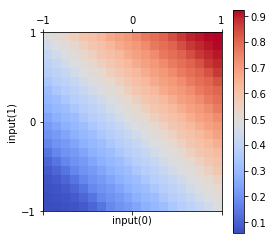

In [23]:
test_net(net)

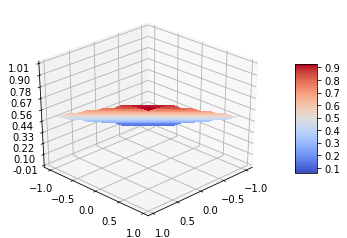

In [26]:
plot_net(net, 45)

In [27]:
from ipywidgets import interact
import ipywidgets as widgets

In [43]:
interact(lambda i1, i2: untherm(net.propagate([i1, i2])), 
         i1=widgets.FloatSlider(description="i1",min=-1, max=1,step=.1),
         i2=widgets.FloatSlider(description="i2",min=-1, max=1,step=.1))

<function __main__.<lambda>>

In [28]:
def plot_net_angle(angle):
    plot_net(net, angle=angle)

In [29]:
interact(plot_net_angle, angle=widgets.IntSlider(min=-180,max=180,step=10,value=45));

In [44]:
net = Network(2, 2, 1, 10, activation_function=T.nnet.sigmoid)

In [45]:
net.set_inputs([[random.random() * 2 - 1, random.random() * 2 - 1] for i in range(1000)])

In [46]:
net.set_target_function(lambda ins: therm((ins[0] + ins[1])/2))

In [47]:
net.train(report_rate=20, tolerance=0.3)

--------------------------------------------------
Training for max trails: 5000 ...
Epoch: 0 TSS error: 2850.16701736 %correct: 0.0
Epoch: 20 TSS error: 207.14527796 %correct: 46.400000000000006
Epoch: 40 TSS error: 131.305744423 %correct: 67.80000000000001
Epoch: 60 TSS error: 170.721752656 %correct: 48.6
Epoch: 80 TSS error: 138.248276938 %correct: 64.0
Epoch: 100 TSS error: 204.140035426 %correct: 39.6
Epoch: 120 TSS error: 148.885256449 %correct: 61.5
Epoch: 140 TSS error: 144.722290294 %correct: 56.599999999999994
Epoch: 160 TSS error: 188.022897024 %correct: 56.699999999999996
Epoch: 180 TSS error: 117.391768592 %correct: 66.10000000000001
Epoch: 200 TSS error: 265.415587326 %correct: 36.7
Epoch: 220 TSS error: 233.991274135 %correct: 40.5
Epoch: 240 TSS error: 269.748310176 %correct: 39.800000000000004
Epoch: 260 TSS error: 188.110259912 %correct: 47.599999999999994
Epoch: 280 TSS error: 277.862951901 %correct: 26.0
Epoch: 300 TSS error: 102.492181463 %correct: 84.1
Epoch: 320 

KeyboardInterrupt: 